#setup

Import common packages

In [ ]:
import argparse, datetime, glob
import itertools as it
from multiprocessing import cpu_count, Pool
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random, re, requests, shutil
from requests.adapters import HTTPAdapter, Retry
from scipy.stats import hmean
import sklearn.metrics
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import subprocess as sp
import sys
import tempfile as tf
import time
from tqdm import tqdm as progressMonitor

Enable Google Colab, mount drives, and load/define proprietary modules

In [ ]:
%%capture
from google.colab import drive, files, output
drive.mount('/content/drive', force_remount=True)
!rm -r sample_data/

Define directories and principal object paths

In [ ]:
rootDir = '/content/drive/MyDrive/Colab Notebooks/'
#rootDir = '/content/drive/MyDrive/'
workDir = rootDir + 'Primary Research/JLMwSCBC_notebook/'
workDir_elcfs = rootDir + 'Primary Research/proteinPairs_complexMaps/'
workDir_other = rootDir + 'otherStudies/'

In [ ]:
sys.path.insert(0, rootDir)
sys.path.append(workDir)
sys.path.append(workDir_elcfs)
sys.path.append(workDir_other)

#utils

In [ ]:
def flatten(l):
  return [item for sublist in l for item in sublist]

In [ ]:
def generatePairs_all(prots):
  return [frozenset(pair) for pair in list(it.combinations(prots, 2))]

In [ ]:
def calculateIndex_jaccard(listA, listB):
  jaccardIndex = \
    len(set(listA).intersection(set(listB)))/len(set(listA).union(set(listB)))

  return jaccardIndex

#load data into useful structure *(clean up)*

In [ ]:
clusterPredictions_analysesData = \
  pickle.load(open(workDir_other + 'intersectionSet_drew2021_expandedPairs-set/' +
                 'clusterONE_MCL_predictions_sharedPairs_gridSearch_ribosomalSubunit_evalCORUM_evalSTRING.pkl', 'rb'))

In [ ]:
glob.glob(workDir_other + 'cellSpecific_complexDifferences/*')

['/content/drive/MyDrive/otherStudies/cellSpecific_complexDifferences/clusterONE_predictions_overlappingPairs_ELCFS_h322_t0.28_0_nodes_2_0.1_0.6.txt',
 '/content/drive/MyDrive/otherStudies/cellSpecific_complexDifferences/clusterONE_predictions_overlappingPairs_ELCFS_mcf7_t0.28_0_nodes_2_0.1_0.6.txt',
 '/content/drive/MyDrive/otherStudies/cellSpecific_complexDifferences/clusterONE_predictions_overlappingPairs_ELCFS_u251_t0.28_0_nodes_2_0.1_0.6.txt',
 '/content/drive/MyDrive/otherStudies/cellSpecific_complexDifferences/clusterONE_predictions_overlappingPairs_ELCFS_h322_t0.28_4_nodes_2_0.30000000000000004_0.6.txt',
 '/content/drive/MyDrive/otherStudies/cellSpecific_complexDifferences/clusterONE_predictions_overlappingPairs_ELCFS_mcf7_t0.28_4_nodes_2_0.30000000000000004_0.6.txt',
 '/content/drive/MyDrive/otherStudies/cellSpecific_complexDifferences/clusterONE_predictions_overlappingPairs_ELCFS_u251_t0.28_4_nodes_2_0.30000000000000004_0.6.txt',
 '/content/drive/MyDrive/otherStudies/cellSpec

In [ ]:
cellSpecific_complexDifferences_prtn = \
  pickle.load(open(workDir_other + 'cellSpecific_complexDifferences/cellSpecific_complexDifferences_DICT.pkl', 'rb'))

In [ ]:
pickle.dump(cellSpecific_complexDifferences_prtn,
            open(workDir_other + 'cellSpecific_complexDifferences/cellSpecific_complexDifferences_DICT.pkl', 'wb'))

In [ ]:
cellSpecific_complexDifferences.keys()

dict_keys(['clusterONE_predictions_overlappingPairs_ELCFS_h322_t0.28_0_nodes_2_0.1_0.6.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_mcf7_t0.28_0_nodes_2_0.1_0.6.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_u251_t0.28_0_nodes_2_0.1_0.6.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_h322_t0.28_4_nodes_2_0.30000000000000004_0.6.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_mcf7_t0.28_4_nodes_2_0.30000000000000004_0.6.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_u251_t0.28_4_nodes_2_0.30000000000000004_0.6.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_h322_t0.29333333333333333_3_nodes_2_0.2_0.7.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_mcf7_t0.29333333333333333_3_nodes_2_0.2_0.7.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_u251_t0.29333333333333333_3_nodes_2_0.2_0.7.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_h322_t0.3066666666666667_0_nodes_2_0.1_0.6.txt', 'clusterONE_predictions_overlappingPairs_ELCFS_mcf7_t0.3066666

In [ ]:
paramsSet = \
  ['t0.28_0_nodes_2_0.1_0.6',
   't0.28_4_nodes_2_0.30000000000000004_0.6',
   't0.29333333333333333_3_nodes_2_0.2_0.7',
   't0.3066666666666667_0_nodes_2_0.1_0.6']

cellSpecific_complexDifferences_prtn = {}
for param in paramsSet:
  tempDict = dict()
  for cellLine in ['h322', 'mcf7', 'u251']:
    for ele in list(cellSpecific_complexDifferences.keys()):
      if (param in ele) & (cellLine in ele):
        tempDict[cellLine] = cellSpecific_complexDifferences[ele]
        break
  cellSpecific_complexDifferences_prtn[param] = tempDict

In [ ]:
cellSpecific_complexDifferences_prtn.keys()

dict_keys(['t0.28_0_nodes_2_0.1_0.6', 't0.28_4_nodes_2_0.30000000000000004_0.6t0.29333333333333333_3_nodes_2_0.2_0.7', 't0.3066666666666667_0_nodes_2_0.1_0.6'])

#analysis

##update or load saved results

In [ ]:
cellSpecific_complexes = pickle.load(open(
                workDir_other + 'cellSpecific_complexDifferences/' +
                'cellSpecific_complexDifferences_scored.pkl', 'rb'))

In [ ]:
pairCounts = pickle.load(open(
    workDir_other + 'cellSpecific_complexDifferences/' +
    'cellSpecific_complexDifferences_pairCounts.pkl', 'rb'))

In [ ]:
pairCounts_mapping = pickle.load(open(
    workDir_other + 'cellSpecific_complexDifferences/' +
    'pairCounts_mapping.pkl', 'rb'))

In [ ]:
pickle.dump(cellSpecific_complexes, open(
    workDir_other + 'cellSpecific_complexDifferences/' +
    'cellSpecific_complexDifferences_scored.pkl', 'wb'))

In [ ]:
pickle.dump(pairCounts, open(
    workDir_other + 'cellSpecific_complexDifferences/' +
    'cellSpecific_complexDifferences_pairCounts.pkl', 'wb'))

In [ ]:
pickle.dump(pairCounts_mapping, open(
    workDir_other + 'cellSpecific_complexDifferences/' +
    'pairCounts_mapping.pkl', 'wb'))

##complexes

In [ ]:
for param in cellSpecific_complexDifferences_prtn.keys():
  for cellLine, assembly in cellSpecific_complexDifferences_prtn[param].items():
    cellSpecific_complexDifferences_prtn[param][cellLine] = \
      [frozenset(cplx) for cplx in assembly]

In [ ]:
allComplexes = dict()
for param in cellSpecific_complexDifferences_prtn.keys():
  allComplexes[param] = []
  for assembly in cellSpecific_complexDifferences_prtn[param].values():
    for cplx in assembly:
      allComplexes[param].append(cplx)
  allComplexes[param] = list(set(allComplexes[param]))

In [ ]:
cellSpecific_complexes = \
  {params: pd.DataFrame(
      {'complex': assembly,
       'complexLength': [len(cplx) for cplx in assembly],
       'complexPairs_all': [generatePairs_all(list(cplx)) for cplx in assembly],
       'h322Present':
        [1 if cplx in set(cellSpecific_complexDifferences_prtn[params]['h322'])
         else 0 for cplx in assembly],
       'mcf7Present':
        [1 if cplx in set(cellSpecific_complexDifferences_prtn[params]['mcf7'])
         else 0 for cplx in assembly],
       'u251Present':
        [1 if cplx in set(cellSpecific_complexDifferences_prtn[params]['u251'])
         else 0 for cplx in assembly]})
  for params, assembly in allComplexes.items()}

##comparisons with CORUM and STRING

In [ ]:
corum2018_humanComplexes = \
  pickle.load(open('/content/corumComplexes_geneIDs_2018.09.03.pkl','rb'))
corum2018_humanComplexes = \
  set(corum2018_humanComplexes)

stringLatest_humanComplexes = \
  pickle.load(open('/content/stringComplexes_geneidMapped.pkl','rb'))
stringLatest_humanComplexes = \
  set(stringLatest_humanComplexes)

In [ ]:
corum2018_humanComplexes_setAdjusted = \
  [ref.intersection(expandedPairsset_proteins)
  for ref in corum2018_humanComplexes if len(ref.intersection(expandedPairsset_proteins))>2]

stringLatest_humanComplexes_setAdjusted = \
  [ref.intersection(expandedPairsset_proteins)
  for ref in stringLatest_humanComplexes if len(ref.intersection(expandedPairsset_proteins))>2]

In [ ]:
pickle.dump(corum2018_humanComplexes_setAdjusted,
            open(workDir_other + 'cellSpecific_complexDifferences/' +
                 'corum2018_humanComplexes_setAdjusted.pkl', 'wb'))
pickle.dump(stringLatest_humanComplexes_setAdjusted,
            open(workDir_other + 'cellSpecific_complexDifferences/' +
                 'stringLatest_humanComplexes_setAdjusted.pkl', 'wb'))

In [ ]:
for param, df in cellSpecific_complexes.items():
  print(df.shape)

  print('CORUM--member, subset, superset')
  df.insert(3, 'memberCORUM',
            [1 if cplx in corum2018_humanComplexes_setAdjusted else 0
             for cplx in df.loc[:, 'complex'].to_list()])
  print(sum([1 if cplx in corum2018_humanComplexes_setAdjusted else 0
             for cplx in df.loc[:, 'complex'].to_list()]))
  df.insert(4, 'subsetCORUM',
            [1 if any([cplx.issubset(ref)
            for ref in list(corum2018_humanComplexes_setAdjusted)]) else 0
             for cplx in df.loc[:, 'complex'].to_list()])
  print(sum([1 if any([cplx.issubset(ref)
            for ref in list(corum2018_humanComplexes_setAdjusted)]) else 0
             for cplx in df.loc[:, 'complex'].to_list()]))
  df.insert(5, 'supersetCORUM',
            [1 if any([cplx.issuperset(ref)
            for ref in list(corum2018_humanComplexes_setAdjusted)]) else 0
             for cplx in df.loc[:, 'complex'].to_list()])
  print(sum([1 if any([cplx.issuperset(ref)
            for ref in list(corum2018_humanComplexes_setAdjusted)]) else 0
             for cplx in df.loc[:, 'complex'].to_list()]))

  print('STRING--member, subset, superset')
  df.insert(6, 'memberSTRING',
          [1 if cplx in stringLatest_humanComplexes_setAdjusted else 0
            for cplx in df.loc[:, 'complex'].to_list()])
  print(sum([1 if cplx in corum2018_humanComplexes_setAdjusted else 0
             for cplx in df.loc[:, 'complex'].to_list()]))
  df.insert(7, 'subsetSTRING',
            [1 if any([cplx.issubset(ref)
            for ref in list(stringLatest_humanComplexes_setAdjusted)]) else 0
             for cplx in df.loc[:, 'complex'].to_list()])
  print(sum([1 if any([cplx.issubset(ref)
            for ref in list(stringLatest_humanComplexes_setAdjusted)]) else 0
             for cplx in df.loc[:, 'complex'].to_list()]))
  df.insert(8, 'supersetSTRING',
            [1 if any([cplx.issuperset(ref)
            for ref in list(stringLatest_humanComplexes_setAdjusted)]) else 0
             for cplx in df.loc[:, 'complex'].to_list()])
  print(sum([1 if any([cplx.issuperset(ref)
            for ref in list(stringLatest_humanComplexes_setAdjusted)]) else 0
             for cplx in df.loc[:, 'complex'].to_list()]))

  cellSpecific_complexes[param] = df

##ppi

In [ ]:
ppiScores_cellSpecific_elcfsPath = workDir + 'modelPerformance/' + \
  'modelsPerformance_integratedPairs_KD+LM+FGK+SCBC_' + \
  'cellSpecific_nci60Feats_noSCBCnulls-5CV/resultsConcatenated/' + \
  'probsPos-weighted_wlabeledPairs_reportingCelllines-H322+MCF7+U251.pkl'
ppiScores_cellSpecific_elcfs = \
  pickle.load(open(ppiScores_cellSpecific_elcfsPath, 'rb'))

In [ ]:
ppiScores_cellSpecific_elcfs.rename(columns={'probsPos_h322': 'h322',
                                             'probsPos_mcf7': 'mcf7',
                                             'probsPos_u251': 'u251',
                                             'probsPos_mean': 'nonspecific'},
                                    inplace=True)

ppiScores_cellSpecific_elcfs.drop(columns=['labels', 'nonspecific'],
                                  inplace=True)

In [ ]:
expandedPairsset = ppiScores_cellSpecific_elcfs.idsFrozen.to_list()
expandedPairsset_proteins = set(list(set().union(*expandedPairsset)))

In [ ]:
for param, df in cellSpecific_complexes.items():
  print(param)
  relPairs = \
    [list(set(pairs).intersection(expandedPairsset))
    for pairs in df.complexPairs_all.to_list()]
  df.insert(3, 'complexPairs_rel', relPairs)
  cellSpecific_complexes[param] = df

In [ ]:
#don't assume, define 0, for the complex score (min, mean)
for param, df in cellSpecific_complexes.items():
  print(param)
  for cellLine in ['h322', 'mcf7', 'u251']:
    print(cellLine)
    #init
    df[cellLine + 'min_complexScore'] = 0
    df[cellLine + 'mean_complexScore'] = 0

    relPairs = \
      df.loc[df[cellLine + 'Present']==1,
             'complexPairs_rel'].to_list()
    minScores = \
      [ppiScores_cellSpecific_elcfs.loc[
          ppiScores_cellSpecific_elcfs.idsFrozen.isin(pairs), cellLine].min()
          for pairs in relPairs]
    meanScores = \
      [ppiScores_cellSpecific_elcfs.loc[
          ppiScores_cellSpecific_elcfs.idsFrozen.isin(pairs), cellLine].mean()
          for pairs in relPairs]
    df.loc[df[cellLine + 'Present']==1,
             cellLine + 'min_complexScore'] = minScores
    df.loc[df[cellLine + 'Present']==1,
             cellLine + 'mean_complexScore'] = meanScores

  cellSpecific_complexes[param] = df

t0.28_0_nodes_2_0.1_0.6
h322
mcf7
u251
t0.28_4_nodes_2_0.30000000000000004_0.6
h322
mcf7
u251
t0.29333333333333333_3_nodes_2_0.2_0.7
h322
mcf7
u251
t0.3066666666666667_0_nodes_2_0.1_0.6
h322
mcf7
u251


In [ ]:
for param, df in cellSpecific_complexes.items():
  df.loc[:, 'h322min_mcf7min_difference'] = \
    abs(df.loc[:, 'h322min_complexScore'] - df.loc[:, 'mcf7min_complexScore'])
  df.loc[:, 'h322min_u251min_difference'] = \
    abs(df.loc[:, 'h322min_complexScore'] - df.loc[:, 'u251min_complexScore'])
  df.loc[:, 'mcf7min_u251min_difference'] = \
    abs(df.loc[:, 'mcf7min_complexScore'] - df.loc[:, 'u251min_complexScore'])

  df.loc[:, 'h322mean_mcf7mean_difference'] = \
    abs(df.loc[:, 'h322mean_complexScore'] - df.loc[:, 'mcf7mean_complexScore'])
  df.loc[:, 'h322mean_u251mean_difference'] = \
    abs(df.loc[:, 'h322mean_complexScore'] - df.loc[:, 'u251mean_complexScore'])
  df.loc[:, 'mcf7mean_u251mean_difference'] = \
    abs(df.loc[:, 'mcf7mean_complexScore'] - df.loc[:, 'u251mean_complexScore'])

  cellSpecific_complexes[param] = df

add columns for the max of the min, mean diff columns

In [ ]:
for param, df in cellSpecific_complexes.items():
  print(param)

  df['minDiff_max'] = df.loc[:,
  ['h322min_mcf7min_difference',
  'h322min_u251min_difference',
  'mcf7min_u251min_difference']].max(axis=1)
  df['meanDiff_max'] = df.loc[:,
   ['h322mean_mcf7mean_difference',
    'h322mean_u251mean_difference',
    'mcf7mean_u251mean_difference']].max(axis=1)

  cellSpecific_complexes[param] = df

t0.28_0_nodes_2_0.1_0.6
t0.28_4_nodes_2_0.30000000000000004_0.6
t0.29333333333333333_3_nodes_2_0.2_0.7
t0.3066666666666667_0_nodes_2_0.1_0.6


In [ ]:
for param, df in cellSpecific_complexes.items():
  print(param)

  df['minDiff_min'] = df.loc[:,
  ['h322min_mcf7min_difference',
  'h322min_u251min_difference',
  'mcf7min_u251min_difference']].min(axis=1)
  df['meanDiff_min'] = df.loc[:,
   ['h322mean_mcf7mean_difference',
    'h322mean_u251mean_difference',
    'mcf7mean_u251mean_difference']].min(axis=1)

  cellSpecific_complexes[param] = df

t0.28_0_nodes_2_0.1_0.6
t0.28_4_nodes_2_0.30000000000000004_0.6
t0.29333333333333333_3_nodes_2_0.2_0.7
t0.3066666666666667_0_nodes_2_0.1_0.6


In [ ]:
for param, df in cellSpecific_complexes.items():
  print(param)

  diffCols_min = \
    [col for col in df.columns.to_list()
    if all([substring in col for substring in ['min', 'difference']])]
  diffCols_mean = \
    [col for col in df.columns.to_list()
    if all([substring in col for substring in ['mean', 'difference']])]

  colTarget_min = \
    [', '.join([col for col in diffCols_min if row[col]==row.minDiff_min])
     for _, row in df.iterrows()]
  colTarget_mean = \
    [', '.join([col for col in diffCols_mean if row[col]==row.meanDiff_min])
     for _, row in df.iterrows()]

  df['minDiff_minPair'] = colTarget_min
  df['meanDiff_minPair'] = colTarget_mean

t0.28_0_nodes_2_0.1_0.6
t0.28_4_nodes_2_0.30000000000000004_0.6
t0.29333333333333333_3_nodes_2_0.2_0.7
t0.3066666666666667_0_nodes_2_0.1_0.6


more efficient if added/integrated into earlier complex-pairs retrieval/identification phase

In [ ]:
#want top scoring pairs, their values and corresponding cell lines (col checksum=3)
cellLines = ['h322', 'mcf7', 'u251']
for param, df in cellSpecific_complexes.items():
  print(param)

  maxScores = \
    [ppiScores_cellSpecific_elcfs.loc[
        ppiScores_cellSpecific_elcfs.idsFrozen.isin(row.complexPairs_rel),
        cellLines].max().max() for _, row in df.iterrows()]

  maxScoring_pairsPlus_cellLines = \
    [flatten([
        [ppiScores_cellSpecific_elcfs.loc[
            tempDF.any(axis=1).index, 'idsFrozen'].to_list(),
         ', '.join(ppiScores_cellSpecific_elcfs.columns[tempDF.any()].to_list())]
        for tempDF in [ppiScores_cellSpecific_elcfs.loc[
            ppiScores_cellSpecific_elcfs.idsFrozen.isin(
                row.complexPairs_rel), :] == maxScores[i]]])
    for i, row in df.iterrows()]

  maxScores_pairs_cellLines = \
    pd.concat(
        [pd.DataFrame({'maxScore_pairs': maxScores}),
         pd.DataFrame(maxScoring_pairsPlus_cellLines,
                      columns=['maxScoring_pairs', 'maxScoring_pairsCells'])],
        axis=1)

  cellSpecific_complexes[param] = \
    pd.concat([df, maxScores_pairs_cellLines], axis=1)

t0.28_0_nodes_2_0.1_0.6
t0.28_4_nodes_2_0.30000000000000004_0.6
t0.29333333333333333_3_nodes_2_0.2_0.7
t0.3066666666666667_0_nodes_2_0.1_0.6


In [ ]:
# want top scoring pairs, their values and corresponding cell lines (col checksum=3)
cellLines = ['h322', 'mcf7', 'u251']
for param, df in cellSpecific_complexes.items():
  print(param)

  minScores = \
    [ppiScores_cellSpecific_elcfs.loc[
        ppiScores_cellSpecific_elcfs.idsFrozen.isin(row.complexPairs_rel),
        cellLines].min().min() for _, row in df.iterrows()]

  minScoring_pairsPlus_cellLines = \
    [flatten([
        [ppiScores_cellSpecific_elcfs.loc[
            tempDF.any(axis=1).index, 'idsFrozen'].to_list(),
         ', '.join(ppiScores_cellSpecific_elcfs.columns[tempDF.any()].to_list())]
        for tempDF in [ppiScores_cellSpecific_elcfs.loc[
            ppiScores_cellSpecific_elcfs.idsFrozen.isin(
                row.complexPairs_rel), :] == minScores[i]]])
    for i, row in df.iterrows()]

  minScores_pairs_cellLines = \
    pd.concat(
        [pd.DataFrame({'minScore_pairs': minScores}),
         pd.DataFrame(minScoring_pairsPlus_cellLines,
                      columns=['minScoring_pairs', 'minScoring_pairsCells'])],
        axis=1)

  cellSpecific_complexes[param] = \
    pd.concat([df, minScores_pairs_cellLines], axis=1)

t0.28_0_nodes_2_0.1_0.6
t0.28_4_nodes_2_0.30000000000000004_0.6
t0.29333333333333333_3_nodes_2_0.2_0.7
t0.3066666666666667_0_nodes_2_0.1_0.6


In [ ]:
pairCounts = \
  {param:
   df.explode('complexPairs_rel').value_counts(
      subset=['complexPairs_rel'],
      ascending=False).to_frame().reset_index().rename(
          columns={0: 'counts'})
   for param, df in cellSpecific_complexes.items()}

pairCounts_mapping = \
  {param: df.set_index('complexPairs_rel').to_dict()
  for param, df in pairCounts.items()}

In [ ]:
pairCounts = \
  {param: pd.concat([df,
                     pd.DataFrame(
                        flatten([]),
                        columns=['complexesPresent', 'complexIdx_mapped'])],
                    axis=1)
  for param, df in pairCounts.items()}

In [ ]:
for param, df in cellSpecific_complexes.items():
  print(param)

  df['pairCounts_maxTotal'] = \
    [sum([pairCounts_mapping[param]['counts'][pair]
          for pair in row.complexPairs_rel]) for _, row in df.iterrows()]

  cellSpecific_complexes[param] = df

t0.28_0_nodes_2_0.1_0.6
t0.28_4_nodes_2_0.30000000000000004_0.6
t0.29333333333333333_3_nodes_2_0.2_0.7
t0.3066666666666667_0_nodes_2_0.1_0.6


##look here##

###Completed
*CORUM&STRING (member, subset, superset)

*maxDiff sort

*assess frequency/count of complex predictions across params

*pairs analysis
*   max scoring pair(s)
*   max scoring pair(s) value
*   cell lines of max scoring pair(s)
*   num pairs comprising predicted complexes
*   num appearances (in predicted complexes) for each pair
*   total of each complex's pairs' counts

*perhaps take list of proteins from the intersection of complexes that are most frequently predicted across cell lines and param combinations and for which the number of subunits is experimentally practical with the pairs appearing the most frequently?*

###First priority to do (when no longer tired)

*(look at subset/superset as well, but for what length?)*

*update manuscript table(s)

###Consider?
*least scored? how used--unsure

*Jaccard index, fast--got tired

In [ ]:
for param, df in cellSpecific_complexes.items():
  print(param)
  df['frequency_paramSets'] = \
    [sum(
        [cplx in cellSpecific_complexes[paramOther].loc[:, 'complex'].to_list()
        for paramOther in list(cellSpecific_complexes.keys())
        if paramOther is not param])
        for cplx in df.loc[:, 'complex'].to_list()]

t0.28_0_nodes_2_0.1_0.6
t0.28_4_nodes_2_0.30000000000000004_0.6
t0.29333333333333333_3_nodes_2_0.2_0.7
t0.3066666666666667_0_nodes_2_0.1_0.6


In [ ]:
cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7'].sort_values(by=['meanDiff_max'], ascending=False)

,complex,complexLength,complexPairs_all,memberCORUM,subsetCORUM,supersetCORUM,memberSTRING,subsetSTRING,supersetSTRING,complexPairs_rel,...,h322mean_u251mean_difference,mcf7mean_u251mean_difference,meanDiff_max,minDiff_max,minDiff_maxPair,meanDiff_maxPair,maxScore_pairs,maxScoring_pairs,maxScoring_pairsCells,pairCounts_maxTotal
447,"(5595, 2319, 1499, 1495, 55327)",5,"[(5595, 2319), (2319, 55327), (2319, 1499), (2...",0,0,0,0,0,0,"[(2319, 1499), (1499, 1495), (5595, 1499), (55...",...,0.775657,0.008371,0.775657,0.470318,h322min_u251min_difference,h322mean_u251mean_difference,0.955994,"[(5595, 1499), (2319, 1499), (1499, 1495), (55...",mcf7,22
574,"(6638, 282991, 10013, 4361, 6809, 2647)",6,"[(10013, 4361), (282991, 10013), (10013, 2647)...",0,0,0,0,0,0,"[(10013, 6809), (6638, 4361), (10013, 4361), (...",...,0.642489,0.031110,0.673599,0.024063,h322min_u251min_difference,h322mean_mcf7mean_difference,0.999390,"[(6809, 4361), (2647, 4361), (6638, 4361), (10...",u251,19
382,"(54386, 65057, 25913, 64780, 10482)",5,"[(25913, 10482), (65057, 25913), (54386, 25913...",0,0,0,0,0,1,"[(65057, 25913), (64780, 10482), (54386, 25913...",...,0.645748,0.001673,0.645748,0.004374,h322min_mcf7min_difference,h322mean_u251mean_difference,0.969666,"[(54386, 25913), (54386, 10482), (64780, 10482...",u251,22
484,"(8717, 27348, 8915, 5537)",4,"[(8915, 27348), (27348, 5537), (8717, 27348), ...",0,0,0,0,0,0,"[(8717, 8915), (27348, 5537), (8717, 27348), (...",...,0.634376,0.001827,0.636204,0.001250,h322min_mcf7min_difference,h322mean_mcf7mean_difference,1.000000,"[(8717, 5537), (5537, 27348), (8717, 27348), (...","labels, h322, mcf7, u251, nonspecific",64
57,"(84296, 9837, 64785, 51659)",4,"[(64785, 9837), (9837, 51659), (84296, 9837), ...",1,1,1,0,0,0,"[(84296, 9837), (64785, 9837), (84296, 51659),...",...,0.003153,0.635522,0.635522,0.001875,"h322min_mcf7min_difference, mcf7min_u251min_di...",mcf7mean_u251mean_difference,0.986877,"[(84296, 51659), (64785, 9837), (51659, 9837),...",u251,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,"(7402, 23176, 55752, 4735)",4,"[(23176, 55752), (7402, 55752), (4735, 55752),...",0,0,0,0,0,0,"[(7402, 4735), (23176, 55752), (7402, 23176), ...",...,0.000783,0.000670,0.000783,0.000624,h322min_mcf7min_difference,h322mean_u251mean_difference,0.980286,"[(7402, 23176), (7402, 55752), (4735, 7402), (...",h322,39
232,"(3675, 5921, 83737, 3655)",4,"[(5921, 3655), (83737, 3655), (3675, 3655), (5...",0,0,0,0,0,0,"[(3675, 83737), (5921, 3655), (5921, 83737), (...",...,0.000058,0.000416,0.000416,0.001875,h322min_u251min_difference,mcf7mean_u251mean_difference,0.942871,"[(83737, 3655), (5921, 83737), (3675, 83737), ...",u251,35
32,"(23032, 2273)",2,"[(23032, 2273)]",0,0,0,0,0,0,"[(23032, 2273)]",...,0.000305,0.000000,0.000305,0.000305,"h322min_mcf7min_difference, h322min_u251min_di...","h322mean_mcf7mean_difference, h322mean_u251mea...",0.979370,"[(23032, 2273)]","mcf7, u251",10
194,"(51028, 84313)",2,"[(51028, 84313)]",0,1,0,0,0,0,"[(51028, 84313)]",...,0.000305,0.000305,0.000305,0.000305,"h322min_u251min_difference, mcf7min_u251min_di...","h322mean_u251mean_difference, mcf7mean_u251mea...",0.714428,"[(51028, 84313)]",u251,3


In [ ]:
pairCounts['t0.29333333333333333_3_nodes_2_0.2_0.7']

,complexPairs_rel,counts
0,"(8717, 5537)",21
1,"(387, 9804)",17
2,"(2768, 59345)",17
3,"(5537, 27348)",17
4,"(387, 201595)",15
...,...,...
21848,"(23524, 6634)",1
21849,"(9129, 51747)",1
21850,"(51747, 6428)",1
21851,"(57461, 9295)",1


In [ ]:
cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7'].loc[:,
 ['h322Present',	'mcf7Present',	'u251Present', 'memberCORUM', 'subsetCORUM', 'supersetCORUM', 'memberSTRING', 'subsetSTRING', 'supersetSTRING']].sum()

h322Present       340
mcf7Present       444
u251Present       481
memberCORUM         6
subsetCORUM        11
supersetCORUM      91
memberSTRING        0
subsetSTRING        9
supersetSTRING     40
dtype: int64

In [ ]:
cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7'].sort_values(by=['pairCounts_maxTotal'], ascending=False)

,complex,complexLength,complexPairs_all,memberCORUM,subsetCORUM,supersetCORUM,memberSTRING,subsetSTRING,supersetSTRING,complexPairs_rel,...,h322mean_u251mean_difference,mcf7mean_u251mean_difference,meanDiff_max,minDiff_max,minDiff_maxPair,meanDiff_maxPair,maxScore_pairs,maxScoring_pairs,maxScoring_pairsCells,pairCounts_maxTotal
64,"(23405, 6217, 10940, 8971, 59, 6193, 3608, 166...",120,"[(23405, 6187), (23405, 6141), (23405, 6231), ...",0,0,1,0,0,1,"[(6234, 11224), (6132, 4673), (6222, 6228), (5...",...,0.000514,0.000833,0.001347,0.000000,"h322min_mcf7min_difference, h322min_u251min_di...",h322mean_mcf7mean_difference,1.000000,"[(10199, 5981), (84311, 10528), (6129, 10514),...","labels, h322, mcf7, u251, nonspecific",6647
81,"(9782, 6634, 22938, 51340, 51645, 988, 51230, ...",74,"[(85437, 11017), (85437, 22913), (85437, 2483)...",0,0,1,0,0,1,"[(51503, 23020), (22985, 23450), (5411, 23450)...",...,0.192551,0.000000,0.192551,0.000000,"h322min_mcf7min_difference, h322min_u251min_di...","h322mean_mcf7mean_difference, h322mean_u251mea...",1.000000,"[(51503, 10594), (9343, 51340), (64783, 10236)...","labels, h322, mcf7, u251, nonspecific",5093
133,"(22938, 6634, 51340, 11052, 988, 6625, 6633, 1...",64,"[(10250, 11017), (22913, 11017), (57703, 11017...",0,0,0,0,0,1,"[(22985, 23450), (5411, 23450), (24148, 9128),...",...,0.205206,0.000000,0.205206,0.000000,"h322min_mcf7min_difference, h322min_u251min_di...","h322mean_mcf7mean_difference, h322mean_u251mea...",1.000000,"[(6633, 11052), (9343, 51340), (55660, 7919), ...","labels, h322, mcf7, u251, nonspecific",4398
408,"(22938, 6634, 51340, 988, 6636, 6633, 11017, 2...",50,"[(22913, 11017), (11017, 2483), (57703, 11017)...",0,0,0,0,0,1,"[(51503, 23020), (24144, 11017), (3297, 57703)...",...,0.238739,0.002444,0.241184,0.000000,"h322min_mcf7min_difference, h322min_u251min_di...",h322mean_mcf7mean_difference,1.000000,"[(51503, 10594), (9343, 51340), (84844, 6633),...","labels, h322, mcf7, u251, nonspecific",3307
14,"(124995, 64978, 64968, 29088, 65005, 65008, 64...",76,"[(63875, 122704), (64976, 122704), (65008, 122...",0,0,1,0,0,1,"[(54148, 122704), (740, 122704), (65008, 51021...",...,0.001718,0.000507,0.002225,0.000000,"h322min_mcf7min_difference, h322min_u251min_di...",h322mean_mcf7mean_difference,1.000000,"[(60488, 54534), (64975, 51264), (65003, 6183)...","labels, h322, mcf7, u251, nonspecific",2730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,"(51028, 84313)",2,"[(51028, 84313)]",0,1,0,0,0,0,"[(51028, 84313)]",...,0.000305,0.000305,0.000305,0.000305,"h322min_u251min_difference, mcf7min_u251min_di...","h322mean_u251mean_difference, mcf7mean_u251mea...",0.714428,"[(51028, 84313)]",u251,3
275,"(63908, 8774)",2,"[(63908, 8774)]",0,0,0,0,0,0,"[(63908, 8774)]",...,0.002258,0.003784,0.006042,0.006042,h322min_mcf7min_difference,h322mean_mcf7mean_difference,0.883484,"[(63908, 8774)]",h322,3
321,"(596, 598)",2,"[(596, 598)]",0,0,0,0,0,0,"[(596, 598)]",...,0.246264,0.000000,0.246264,0.246264,"h322min_mcf7min_difference, h322min_u251min_di...","h322mean_mcf7mean_difference, h322mean_u251mea...",0.253138,"[(596, 598)]",u251,2
93,"(3430, 9111)",2,"[(3430, 9111)]",0,0,0,0,0,0,"[(3430, 9111)]",...,0.029755,0.004677,0.029755,0.029755,h322min_u251min_difference,h322mean_u251mean_difference,0.368176,"[(3430, 9111)]",u251,1


In [ ]:
cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7'].loc[64, :]

complex                         (23405, 6217, 10940, 8971, 59, 6193, 3608, 166...
complexLength                                                                 120
complexPairs_all                [(23405, 6187), (23405, 6141), (23405, 6231), ...
memberCORUM                                                                     0
subsetCORUM                                                                     0
supersetCORUM                                                                   1
memberSTRING                                                                    0
subsetSTRING                                                                    0
supersetSTRING                                                                  1
complexPairs_rel                [(6234, 11224), (6132, 4673), (6222, 6228), (5...
h322Present                                                                     1
mcf7Present                                                                     1
u251Present     

In [ ]:
testPair = cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7'].loc[23, 'complex']

In [ ]:
ppiScores_cellSpecific_elcfs.loc[ppiScores_cellSpecific_elcfs.idsFrozen==testPair, :]

,idsFrozen,idi,idii,labels,h322,mcf7,u251,nonspecific
221052,"(59345, 2768)",2768,59345,1,0.967529,0.967529,0.967529,0.967529


In [ ]:
cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7'].sort_values(by=['meanDiff_max'], ascending=False)

,complex,complexLength,complexPairs_all,memberCORUM,subsetCORUM,supersetCORUM,memberSTRING,subsetSTRING,supersetSTRING,complexPairs_rel,...,maxScoring_pairs,maxScoring_pairsCells,pairCounts_maxTotal,minDiff_min,meanDiff_min,minDiff_minPair,meanDiff_minPair,minScore_pairs,minScoring_pairs,minScoring_pairsCells
447,"(55327, 1495, 1499, 5595, 2319)",5,"[(2319, 5595), (55327, 2319), (1499, 2319), (1...",0,0,0,0,0,0,"[(1499, 2319), (1499, 1495), (1499, 5595), (14...",...,"[(1499, 5595), (1499, 2319), (1499, 1495), (14...",mcf7,22,0.035637,0.008371,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.434681,"[(1499, 5595), (1499, 2319), (1499, 1495), (14...",mcf7
574,"(282991, 4361, 6638, 6809, 10013, 2647)",6,"[(10013, 4361), (282991, 10013), (10013, 2647)...",0,0,0,0,0,0,"[(10013, 6809), (4361, 6638), (10013, 4361), (...",...,"[(4361, 6809), (4361, 2647), (4361, 6638), (10...",u251,19,0.000002,0.031110,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.023750,"[(4361, 6809), (4361, 2647), (4361, 6638), (10...",h322
382,"(64780, 10482, 25913, 54386, 65057)",5,"[(10482, 25913), (25913, 65057), (25913, 54386...",0,0,0,0,0,1,"[(25913, 65057), (10482, 64780), (25913, 54386...",...,"[(25913, 54386), (10482, 54386), (10482, 64780...",u251,22,0.001249,0.001673,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.003125,"[(25913, 54386), (10482, 54386), (10482, 64780...","h322, u251"
484,"(8915, 5537, 27348, 8717)",4,"[(8915, 27348), (5537, 27348), (27348, 8717), ...",0,0,0,0,0,0,"[(8915, 8717), (5537, 27348), (27348, 8717), (...",...,"[(5537, 8717), (5537, 27348), (27348, 8717), (...","labels, h322, mcf7, u251, nonspecific",64,0.000625,0.001827,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.000625,"[(5537, 8717), (5537, 27348), (27348, 8717), (...",u251
57,"(51659, 64785, 84296, 9837)",4,"[(9837, 64785), (51659, 9837), (84296, 9837), ...",1,1,1,0,0,0,"[(84296, 9837), (9837, 64785), (51659, 84296),...",...,"[(51659, 84296), (9837, 64785), (51659, 9837),...",u251,28,0.000000,0.003153,h322min_u251min_difference,h322mean_u251mean_difference,0.001875,"[(51659, 84296), (9837, 64785), (51659, 9837),...","h322, mcf7, u251"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,"(55752, 4735, 7402, 23176)",4,"[(55752, 23176), (55752, 7402), (55752, 4735),...",0,0,0,0,0,0,"[(7402, 4735), (55752, 23176), (7402, 23176), ...",...,"[(7402, 23176), (55752, 7402), (7402, 4735), (...",h322,39,0.000312,0.000113,h322min_u251min_difference,h322mean_mcf7mean_difference,0.001563,"[(7402, 23176), (55752, 7402), (7402, 4735), (...",mcf7
232,"(5921, 3675, 3655, 83737)",4,"[(5921, 3655), (3655, 83737), (3675, 3655), (5...",0,0,0,0,0,0,"[(3675, 83737), (5921, 3655), (5921, 83737), (...",...,"[(3655, 83737), (5921, 83737), (3675, 83737), ...",u251,35,0.000313,0.000058,h322min_mcf7min_difference,h322mean_u251mean_difference,0.004689,"[(83737, 3655), (5921, 83737), (3675, 83737), ...",u251
32,"(23032, 2273)",2,"[(23032, 2273)]",0,0,0,0,0,0,"[(23032, 2273)]",...,"[(23032, 2273)]","mcf7, u251",10,0.000000,0.000000,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.979065,"[(23032, 2273)]",h322
194,"(84313, 51028)",2,"[(84313, 51028)]",0,1,0,0,0,0,"[(84313, 51028)]",...,"[(84313, 51028)]",u251,3,0.000000,0.000000,h322min_mcf7min_difference,h322mean_mcf7mean_difference,0.714123,"[(84313, 51028)]","h322, mcf7"


In [ ]:
cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7'].loc[
    cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7']['memberCORUM']==1, :].sort_values(
        by=['meanDiff_max'], ascending=False)

,complex,complexLength,complexPairs_all,memberCORUM,subsetCORUM,supersetCORUM,memberSTRING,subsetSTRING,supersetSTRING,complexPairs_rel,...,mcf7mean_u251mean_difference,meanDiff_max,minDiff_max,minDiff_maxPair,meanDiff_maxPair,maxScore_pairs,maxScoring_pairs,maxScoring_pairsCells,pairCounts_maxTotal,frequency_paramSets
57,"(51659, 64785, 84296, 9837)",4,"[(64785, 9837), (51659, 9837), (84296, 9837), ...",1,1,1,0,0,0,"[(84296, 9837), (64785, 9837), (51659, 84296),...",...,0.635522,0.635522,0.001875,"h322min_mcf7min_difference, mcf7min_u251min_di...",mcf7mean_u251mean_difference,0.986877,"[(51659, 84296), (64785, 9837), (51659, 9837),...",u251,28,3
4,"(4801, 4802, 4800)",3,"[(4801, 4800), (4802, 4800), (4801, 4802)]",1,1,1,0,0,0,"[(4801, 4802), (4802, 4800), (4801, 4800)]",...,0.542091,0.542607,0.203148,h322min_mcf7min_difference,h322mean_mcf7mean_difference,0.824087,"[(4802, 4800), (4801, 4802), (4801, 4800)]",mcf7,14,3
369,"(51586, 112950, 9442, 10001, 1024, 55588, 9282...",26,"[(84246, 9282), (84246, 9968), (84246, 400569)...",1,1,1,0,0,1,"[(55090, 9440), (81857, 400569), (9439, 9477),...",...,0.001070,0.477407,0.000000,"h322min_mcf7min_difference, h322min_u251min_di...",h322mean_mcf7mean_difference,0.999084,"[(84246, 10001), (55588, 9443), (9282, 90390),...",h322,636,1
394,"(130340, 10053, 8905, 1174, 162, 164, 8906)",7,"[(162, 10053), (162, 1174), (162, 8906), (162,...",1,1,1,0,0,0,"[(130340, 164), (10053, 164), (8905, 164), (16...",...,0.018596,0.390621,0.000626,h322min_mcf7min_difference,h322mean_mcf7mean_difference,0.950684,"[(162, 10053), (1174, 8906), (130340, 162), (8...",mcf7,75,1
82,"(25913, 65057, 7014)",3,"[(25913, 65057), (25913, 7014), (65057, 7014)]",1,1,1,0,0,0,"[(65057, 7014), (25913, 7014), (25913, 65057)]",...,0.060682,0.067401,0.194390,"h322min_mcf7min_difference, mcf7min_u251min_di...",h322mean_mcf7mean_difference,0.704773,"[(25913, 65057), (25913, 7014), (65057, 7014)]",u251,15,3
97,"(54512, 5393, 51013, 5394, 23016, 56915, 51010...",9,"[(56915, 23404), (51013, 23404), (51010, 23404...",1,1,1,0,0,0,"[(54512, 51013), (54512, 56915), (51010, 23016...",...,0.000804,0.002300,0.000313,"h322min_mcf7min_difference, mcf7min_u251min_di...",h322mean_u251mean_difference,0.991211,"[(51010, 23016), (54512, 11340), (23016, 23404...",h322,36,3


##run a selection for another criterion and sort by meanDiff_max

In [ ]:
cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7'].loc[
    cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7']['subsetSTRING']==1, :].sort_values(
        by=['meanDiff_max'], ascending=False)

,complex,complexLength,complexPairs_all,memberCORUM,subsetCORUM,supersetCORUM,memberSTRING,subsetSTRING,supersetSTRING,complexPairs_rel,...,maxScoring_pairsCells,pairCounts_maxTotal,minDiff_min,meanDiff_min,minDiff_minPair,meanDiff_minPair,minScore_pairs,minScoring_pairs,minScoring_pairsCells,frequency_paramSets
96,"(4000, 595, 3778)",3,"[(595, 3778), (4000, 3778), (4000, 595)]",0,0,0,0,1,0,"[(4000, 595), (595, 3778), (4000, 3778)]",...,u251,24,0.000000,0.013654,"h322min_mcf7min_difference, h322min_u251min_di...",h322mean_u251mean_difference,0.000000,"[(4000, 3778), (4000, 595), (595, 3778)]","h322, mcf7, u251",3
535,"(3910, 9590, 3676, 10788, 4149)",5,"[(3910, 9590), (3676, 9590), (4149, 9590), (10...",0,0,0,0,1,0,"[(3910, 3676), (10788, 9590), (10788, 4149), (...",...,u251,33,0.000625,0.002489,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.004063,"[(10788, 9590), (3676, 4149), (3910, 10788), (...",h322,1
193,"(3910, 9590, 3676, 10788, 4149, 3679)",6,"[(3910, 9590), (3676, 9590), (4149, 9590), (36...",0,0,0,0,1,0,"[(10788, 3679), (3910, 3679), (3910, 3676), (1...",...,u251,48,0.000000,0.000000,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.002500,"[(10788, 9590), (3676, 4149), (10788, 3679), (...",h322,2
315,"(29780, 3611)",2,"[(29780, 3611)]",0,1,0,0,1,0,"[(29780, 3611)]",...,mcf7,6,0.028931,0.028931,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.554656,"[(29780, 3611)]",h322,3
169,"(8772, 841)",2,"[(8772, 841)]",0,1,0,0,1,0,"[(8772, 841)]",...,h322,11,0.003418,0.003418,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.859177,"[(8772, 841)]",mcf7,3
207,"(79803, 84343, 11234, 5290)",4,"[(84343, 5290), (84343, 11234), (79803, 84343)...",0,0,1,0,1,0,"[(84343, 11234), (79803, 11234), (79803, 84343...",...,mcf7,20,0.003727,0.045555,h322min_u251min_difference,h322mean_u251mean_difference,0.175655,"[(79803, 11234), (79803, 84343), (84343, 11234...",u251,3
146,"(3910, 3676, 3679)",3,"[(3910, 3676), (3910, 3679), (3676, 3679)]",0,0,0,0,1,0,"[(3676, 3679), (3910, 3679), (3910, 3676)]",...,u251,18,0.000313,0.000735,h322min_mcf7min_difference,h322mean_mcf7mean_difference,0.434650,"[(3910, 3679), (3910, 3676), (3676, 3679)]",h322,3
244,"(7456, 9459)",2,"[(7456, 9459)]",0,0,0,0,1,0,"[(7456, 9459)]",...,u251,7,0.008698,0.008698,mcf7min_u251min_difference,mcf7mean_u251mean_difference,0.496246,"[(7456, 9459)]",h322,3
156,"(868, 867)",2,"[(868, 867)]",0,0,0,0,1,0,"[(868, 867)]",...,u251,1,0.000000,0.000000,h322min_mcf7min_difference,h322mean_mcf7mean_difference,0.689362,"[(868, 867)]","h322, mcf7",3


In [ ]:
complexesHighest_paramFreq = \
  pd.DataFrame({
      param:
        [df.loc[
            df['frequency_paramSets']==df['frequency_paramSets'].max(),
            'complex'].to_list()]
      for param, df in cellSpecific_complexes.items()
  })

In [ ]:
complexesHighest_paramFreq

,t0.28_0_nodes_2_0.1_0.6,t0.28_4_nodes_2_0.30000000000000004_0.6,t0.29333333333333333_3_nodes_2_0.2_0.7,t0.3066666666666667_0_nodes_2_0.1_0.6
0,"[(4801, 2767, 4802, 4800, 65125), (8668, 8666,...","[(4801, 2767, 4802, 4800, 65125), (8668, 8666,...","[(4801, 4802, 4800), (8668, 8666, 51386, 1861,...","[(4801, 2767, 4802, 4800, 65125), (8668, 8666,..."


In [ ]:
complexesHighest_paramFreq['t0.28_0_nodes_2_0.1_0.6'][0]

In [ ]:
#finds pairs to test for a given complex
#pairsCount is a DF
#cplx is a frozenset of prot ids
def findPairs(cplxRow, pairsCount):
  #print(cplxRow)
  pairs = cplxRow['complexPairs_rel']
  counts = pairsCount.loc[pairsCount['complexPairs_rel'].isin(pairs), :].copy()

  countsHigh = counts.loc[counts['counts']==counts['counts'].max(), :]
  countsHigh_proteins = \
    list(set().union(*[pair
                   for pair in countsHigh.complexPairs_rel.to_list()]))

  countsLow = counts.loc[counts['counts']==counts['counts'].min(), :]
  countsLow_proteins = \
    list(set().union(*[pair
                   for pair in countsLow.complexPairs_rel.to_list()]))

  print(countsHigh_proteins+countsLow_proteins)
  uniprotids, _ = getUniprotids(countsHigh_proteins+countsLow_proteins)
  print(uniprotids)

  return countsHigh, countsHigh_proteins, countsLow, countsLow_proteins, uniprotids

In [ ]:
#map subunit ids programmatically from UniProt.org
def getUniprotids(geneidsList):
  #init
  retries = \
    Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
  session = requests.Session()
  session.mount("https://", HTTPAdapter(max_retries=retries))

  #generate geneid to uniprot id mapping job
  job = \
    "curl --form 'from=\"GeneID\"' \
    --form 'to=\"UniProtKB\"' \
    --form 'ids=\"{0}\"' \
    https://rest.uniprot.org/idmapping/run".format(','.join(geneidsList))

  #submit geneid to uniprot id mapping job
  jobid = os.popen(job).read().split('"')[3]

  #retrieve results from submitted job
  urlAPI = \
    'https://rest.uniprot.org/idmapping/uniprotkb/results/stream/' + \
    '{0}?'.format(jobid) + \
    'fields=accession%2Cxref_geneid&format=tsv&query=%28model_organism%3A9606%29'

  response = session.get(urlAPI)
  response.raise_for_status()

  #convert response into DF
  result = pd.DataFrame([line.split('\t')
    for line in response.text.split('\n') if line])
  result.columns = result.iloc[0, :].to_list()
  result = result.iloc[1:, :].copy()
  result['GeneID'] = result['GeneID'].str.replace(';','')
  uniprotids = list(set(result.Entry.to_list()))

  return uniprotids, result

##run fcn(complexID) for a desired complex as chosen by index or by sort (pref)

###criteria selection

In [ ]:
#most different CORUM (mdC)
mdC = cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6'].loc[
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['memberCORUM']==1), :].sort_values(by=['meanDiff_max'], ascending=False).iloc[0]
print(mdC)

complex                                               (51659, 9837, 84296, 64785)
complexLength                                                                   4
complexPairs_all                [(9837, 64785), (51659, 9837), (84296, 9837), ...
memberCORUM                                                                     1
subsetCORUM                                                                     1
supersetCORUM                                                                   1
memberSTRING                                                                    0
subsetSTRING                                                                    0
supersetSTRING                                                                  0
complexPairs_rel                [(84296, 9837), (9837, 64785), (51659, 84296),...
h322Present                                                                     0
mcf7Present                                                                     1
u251Present     

In [ ]:
print(mdC.complexLength)
print(mdC.frequency_paramSets)
findPairs(mdC, pairCounts['t0.28_0_nodes_2_0.1_0.6'])

4
3
['84296', '64785', '51659', '9837', '64785', '84296']
['Q14691', 'A0A0S2Z5L4', 'A0A0S2Z5L0', 'Q9Y248', 'A0A0S2Z5P2', 'A0A8Q3WLK7', 'Q9BRX5', 'Q9BRT9']


(    complexPairs_rel  counts
 139   (84296, 64785)       9,
 ['84296', '64785'],
     complexPairs_rel  counts
 387    (84296, 9837)       7
 401    (9837, 64785)       7
 426   (51659, 64785)       7
 430   (51659, 84296)       7,
 ['51659', '9837', '64785', '84296'],
 ['Q14691',
  'A0A0S2Z5L4',
  'A0A0S2Z5L0',
  'Q9Y248',
  'A0A0S2Z5P2',
  'A0A8Q3WLK7',
  'Q9BRX5',
  'Q9BRT9'])

In [ ]:
#least different CORUM (ldC)
ldC = cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6'].loc[
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['memberCORUM']==1), :].sort_values(by=['meanDiff_max'], ascending=True).iloc[0]

In [ ]:
print(ldC.complexLength)
print(ldC.frequency_paramSets)
findPairs(ldC, pairCounts['t0.28_0_nodes_2_0.1_0.6'])

9
3
['5394', '51010', '51013', '23404', '54512', '11340', '56915', '5393', '23016', '5394', '51010', '51013', '23404', '54512', '11340', '56915', '5393', '23016']
['Q15024', 'Q01780', 'B3KQW2', 'B1AMU3', 'Q9Y3B2', 'Q13868', 'B4DXG8', 'Q9NQT4', 'Q96B26', 'B2RDZ9', 'A0A024R2T3', 'Q9NPD3', 'Q9NQT5', 'Q06265', 'Q9NYS3']


(      complexPairs_rel  counts
 4563     (23404, 5393)       2
 4626     (5394, 54512)       2
 4851    (51010, 54512)       2
 5241    (56915, 51013)       2
 5281    (23016, 51013)       2
 5475    (51010, 23016)       2
 5478    (11340, 23016)       2
 5516     (5394, 23404)       2
 5537    (11340, 23404)       2
 5633    (23404, 51013)       2
 6555    (11340, 54512)       2
 6699     (56915, 5393)       2
 6719    (11340, 51010)       2
 8759    (11340, 56915)       2
 8894     (54512, 5393)       2
 10243    (5393, 23016)       2
 10290   (56915, 23016)       2
 10365    (5393, 51013)       2
 10406   (11340, 51013)       2
 10463    (11340, 5394)       2
 10561    (11340, 5393)       2
 10614   (23404, 23016)       2
 10862    (5394, 56915)       2
 10918    (5394, 51013)       2
 10976   (56915, 23404)       2
 11119   (51010, 51013)       2
 11155   (56915, 54512)       2
 11257    (5394, 23016)       2
 11594   (54512, 23016)       2
 11781     (5394, 5393)       2
 11876  

In [ ]:
#most different STRING (mdS)
mdS = cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6'].loc[
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['subsetSTRING']==1), :].sort_values(by=['meanDiff_max'], ascending=False).iloc[0]

In [ ]:
print(mdS.complexLength)
print(mdS.frequency_paramSets)
findPairs(mdS, pairCounts['t0.28_0_nodes_2_0.1_0.6'])

3
3
['4000', '595', '4000', '595', '3778']
['A0A087WZL8', 'A0A1W2PPY5', 'P02545', 'A0A1W2PR62', 'A0A1W2PQU4', 'D5MRH1', 'A0A1W2PP94', 'Q5TCI8', 'A0A384MQX1', 'S4R453', 'A0A1W2PR56', 'P24385', 'B7ZMF5', 'A0A1W2PSD3', 'Q6FI00', 'Q5SVJ7', 'A0A1W2PQK5', 'Q12791', 'Q59FH2', 'A0A1W2PRN5']


(    complexPairs_rel  counts
 200      (4000, 595)       8,
 ['4000', '595'],
     complexPairs_rel  counts
 359     (4000, 3778)       7
 362      (595, 3778)       7,
 ['4000', '595', '3778'],
 ['A0A087WZL8',
  'A0A1W2PPY5',
  'P02545',
  'A0A1W2PR62',
  'A0A1W2PQU4',
  'D5MRH1',
  'A0A1W2PP94',
  'Q5TCI8',
  'A0A384MQX1',
  'S4R453',
  'A0A1W2PR56',
  'P24385',
  'B7ZMF5',
  'A0A1W2PSD3',
  'Q6FI00',
  'Q5SVJ7',
  'A0A1W2PQK5',
  'Q12791',
  'Q59FH2',
  'A0A1W2PRN5'])

In [ ]:
#least different STRING (ldS)
ldS = cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6'].loc[
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['subsetSTRING']==1), :].sort_values(by=['meanDiff_max'], ascending=True).iloc[0]

In [ ]:
print(ldS.complexLength)
print(ldS.frequency_paramSets)
findPairs(ldS, pairCounts['t0.28_0_nodes_2_0.1_0.6'])

2
3
['868', '867', '868', '867']
['P22681', 'B7ZAG1', 'B3KSS7', 'B4DYP3', 'Q13191']


(      complexPairs_rel  counts
 37734       (868, 867)       1,
 ['868', '867'],
       complexPairs_rel  counts
 37734       (868, 867)       1,
 ['868', '867'],
 ['P22681', 'B7ZAG1', 'B3KSS7', 'B4DYP3', 'Q13191'])

In [ ]:
#least different STRING (bigger than a pair) (ldS2)
ldS2 = cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6'].loc[
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['subsetSTRING']==1), :].sort_values(by=['meanDiff_max'], ascending=True).iloc[1]

In [ ]:
print(ldS2.complexLength)
print(ldS2.frequency_paramSets)
findPairs(ldS2, pairCounts['t0.28_0_nodes_2_0.1_0.6'])

6
2
['3910', '3679', '3910', '9590', '3676', '10788', '4149', '3679']
['A0A0A0MQS9', 'B7Z7X2', 'Q13683', 'Q13576', 'B7Z7U6', 'Q5D044', 'Q86TJ9', 'A0A024R682', 'Q8TAX8', 'P61244', 'Q02952', 'G3V302', 'Q16363', 'P13612', 'Q4LE35', 'A0A0A0MTC7', 'Q59HA3']


(   complexPairs_rel  counts
 59     (3910, 3679)      13,
 ['3910', '3679'],
       complexPairs_rel  counts
 43894    (10788, 3679)       1
 43895    (10788, 9590)       1
 43896    (10788, 4149)       1
 43899     (3676, 4149)       1
 43916    (3676, 10788)       1
 43917    (3910, 10788)       1,
 ['3910', '9590', '3676', '10788', '4149', '3679'],
 ['A0A0A0MQS9',
  'B7Z7X2',
  'Q13683',
  'Q13576',
  'B7Z7U6',
  'Q5D044',
  'Q86TJ9',
  'A0A024R682',
  'Q8TAX8',
  'P61244',
  'Q02952',
  'G3V302',
  'Q16363',
  'P13612',
  'Q4LE35',
  'A0A0A0MTC7',
  'Q59HA3'])

In [ ]:
#most different novel (mdN)
mdN = cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6'].loc[(
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['memberCORUM']==0) &
     (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['subsetCORUM']==0) &
      (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetCORUM']==0) &
     (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0) &
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0) &
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0)), :].sort_values(by=['meanDiff_max'], ascending=False).iloc[0]

In [ ]:
mdN

complex                                                 (80223, 9688, 8452, 2152)
complexLength                                                                   4
complexPairs_all                [(80223, 9688), (80223, 8452), (80223, 2152), ...
memberCORUM                                                                     0
subsetCORUM                                                                     0
supersetCORUM                                                                   0
memberSTRING                                                                    0
subsetSTRING                                                                    0
supersetSTRING                                                                  0
complexPairs_rel                [(80223, 8452), (8452, 2152), (9688, 2152), (9...
h322Present                                                                     1
mcf7Present                                                                     1
u251Present     

use mdN.complexPairs_rel indexed into the scores for each cell types

In [ ]:
ppiScores_cellSpecific_elcfs.columns.to_list()

['idsFrozen', 'idi', 'idii', 'h322', 'mcf7', 'u251']

In [ ]:
ppiScores_cellSpecific_elcfs.loc[ppiScores_cellSpecific_elcfs.idsFrozen.isin(mdN.complexPairs_rel), :]

,idsFrozen,idi,idii,h322,mcf7,u251
166390,"(9688, 8452)",9688,8452,0.998779,0.998413,0.998779
296870,"(80223, 8452)",80223,8452,0.988403,0.988098,0.989014
389303,"(8452, 2152)",8452,2152,0.189682,0.191566,0.181252
530195,"(9688, 2152)",9688,2152,0.014688,0.015941,0.016252


In [ ]:
cellSpecific_complexes.keys()

dict_keys(['t0.28_0_nodes_2_0.1_0.6', 't0.28_4_nodes_2_0.30000000000000004_0.6', 't0.29333333333333333_3_nodes_2_0.2_0.7', 't0.3066666666666667_0_nodes_2_0.1_0.6'])

In [ ]:
print(mdN.complexLength)
print(mdN.frequency_paramSets)
findPairs(mdN, pairCounts['t0.28_0_nodes_2_0.1_0.6'])

4
3
['8452', '80223', '9688', '2152', '8452', '80223', '9688', '2152']
['P13726', 'Q13618', 'B7Z600', 'Q8N1F7', 'Q6WKZ4', 'A0A024R475']


(     complexPairs_rel  counts
 1642     (9688, 2152)       4
 1683     (8452, 2152)       4
 1684    (8452, 80223)       4
 1719     (8452, 9688)       4,
 ['8452', '80223', '9688', '2152'],
      complexPairs_rel  counts
 1642     (9688, 2152)       4
 1683     (8452, 2152)       4
 1684    (8452, 80223)       4
 1719     (8452, 9688)       4,
 ['8452', '80223', '9688', '2152'],
 ['P13726', 'Q13618', 'B7Z600', 'Q8N1F7', 'Q6WKZ4', 'A0A024R475'])

In [ ]:
#least different novel (ldN)
ldN = cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6'].loc[(
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['memberCORUM']==0) &
     (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['subsetCORUM']==0) &
      (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetCORUM']==0) &
     (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0) &
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0) &
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0)), :].sort_values(by=['meanDiff_max'], ascending=True).iloc[0]

In [ ]:
print(ldN.complexLength)
print(ldN.frequency_paramSets)
findPairs(ldN, pairCounts['t0.28_0_nodes_2_0.1_0.6'])

2
3
['2768', '59345', '2768', '59345']
['Q03113', 'E9PC54', 'Q9HAV0', 'Q6ZQV4']


(   complexPairs_rel  counts
 16    (2768, 59345)      17,
 ['2768', '59345'],
    complexPairs_rel  counts
 16    (2768, 59345)      17,
 ['2768', '59345'],
 ['Q03113', 'E9PC54', 'Q9HAV0', 'Q6ZQV4'])

In [ ]:
#least different novel (bigger than a pair)
ldN2 = cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6'].loc[(
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['memberCORUM']==0) &
     (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['subsetCORUM']==0) &
      (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetCORUM']==0) &
     (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0) &
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0) &
    (cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['supersetSTRING']==0)), :].sort_values(by=['meanDiff_max'], ascending=True).iloc[2]

In [ ]:
print(ldN2)

complex                                                (55752, 23176, 7402, 4735)
complexLength                                                                   4
complexPairs_all                [(55752, 23176), (55752, 7402), (55752, 4735),...
memberCORUM                                                                     0
subsetCORUM                                                                     0
supersetCORUM                                                                   0
memberSTRING                                                                    0
subsetSTRING                                                                    0
supersetSTRING                                                                  0
complexPairs_rel                [(7402, 4735), (55752, 23176), (7402, 23176), ...
h322Present                                                                     1
mcf7Present                                                                     1
u251Present     

In [ ]:
print(ldN2.complexLength)
print(ldN2.frequency_paramSets)
findPairs(ldN2, pairCounts['t0.28_0_nodes_2_0.1_0.6'])

4
3
['23176', '4735', '55752', '7402', '23176', '4735', '55752']
['Q92599', 'Q6LBS5', 'Q9NVA2', 'A6NFQ9', 'A0A384P5S0', 'A0A384N6H6', 'B7ZVZ1', 'P46939', 'Q15019']


(   complexPairs_rel  counts
 64    (4735, 23176)      12
 69    (4735, 55752)      12
 75   (23176, 55752)      12,
 ['23176', '4735', '55752'],
     complexPairs_rel  counts
 133    (7402, 23176)       9
 144     (4735, 7402)       9
 147    (7402, 55752)       9,
 ['7402', '23176', '4735', '55752'],
 ['Q92599',
  'Q6LBS5',
  'Q9NVA2',
  'A6NFQ9',
  'A0A384P5S0',
  'A0A384N6H6',
  'B7ZVZ1',
  'P46939',
  'Q15019'])

*for each of these proteins, list all complexes they contain and corresponding information on CORUM, STRING subset, member, etc., etc.,*

*add to print out the cell lines*

In [ ]:
concatenatedUniprotids = ['Q14691',
  'A0A0S2Z5L4',
  'A0A0S2Z5L0',
  'Q9Y248',
  'A0A0S2Z5P2',
  'A0A8Q3WLK7',
  'Q9BRX5',
  'Q9BRT9',
 'Q15024',
  'Q01780',
  'B3KQW2',
  'B1AMU3',
  'Q9Y3B2',
  'Q13868',
  'B4DXG8',
  'Q9NQT4',
  'Q96B26',
  'B2RDZ9',
  'A0A024R2T3',
  'Q9NPD3',
  'Q9NQT5',
  'Q06265',
  'Q9NYS3',
 'A0A087WZL8',
  'A0A1W2PPY5',
  'P02545',
  'A0A1W2PR62',
  'A0A1W2PQU4',
  'D5MRH1',
  'A0A1W2PP94',
  'Q5TCI8',
  'A0A384MQX1',
  'S4R453',
  'A0A1W2PR56',
  'P24385',
  'B7ZMF5',
  'A0A1W2PSD3',
  'Q6FI00',
  'Q5SVJ7',
  'A0A1W2PQK5',
  'Q12791',
  'Q59FH2',
  'A0A1W2PRN5',
 'P22681', 'B7ZAG1', 'B3KSS7', 'B4DYP3', 'Q13191',
 'A0A0A0MQS9',
  'B7Z7X2',
  'Q13683',
  'Q13576',
  'B7Z7U6',
  'Q5D044',
  'Q86TJ9',
  'A0A024R682',
  'Q8TAX8',
  'P61244',
  'Q02952',
  'G3V302',
  'Q16363',
  'P13612',
  'Q4LE35',
  'A0A0A0MTC7',
  'Q59HA3',
 'P13726', 'Q13618', 'B7Z600', 'Q8N1F7', 'Q6WKZ4', 'A0A024R475',
 'Q03113', 'E9PC54', 'Q9HAV0', 'Q6ZQV4',
 'Q92599',
  'Q6LBS5',
  'Q9NVA2',
  'A6NFQ9',
  'A0A384P5S0',
  'A0A384N6H6',
  'B7ZVZ1',
  'P46939',
  'Q15019'
 ]

In [ ]:
len(set(concatenatedUniprotids))

84

###uniprot ids for antibodies

In [ ]:
list(set(concatenatedUniprotids))

['B1AMU3',
 'Q13618',
 'A0A024R682',
 'P02545',
 'B7Z7U6',
 'B4DXG8',
 'B7ZVZ1',
 'Q9BRT9',
 'P46939',
 'A0A024R475',
 'Q59HA3',
 'Q9NVA2',
 'Q6ZQV4',
 'P22681',
 'B7Z600',
 'Q01780',
 'A6NFQ9',
 'Q9Y248',
 'Q12791',
 'A0A8Q3WLK7',
 'Q6WKZ4',
 'Q13191',
 'Q13683',
 'A0A1W2PPY5',
 'Q86TJ9',
 'A0A1W2PR62',
 'Q16363',
 'P13612',
 'B7Z7X2',
 'A0A1W2PQU4',
 'P13726',
 'Q9Y3B2',
 'Q13868',
 'A0A1W2PP94',
 'Q5TCI8',
 'A0A384MQX1',
 'B4DYP3',
 'Q5D044',
 'B3KQW2',
 'A0A0S2Z5L0',
 'Q5SVJ7',
 'A0A0S2Z5P2',
 'A0A1W2PQK5',
 'Q9NQT5',
 'Q59FH2',
 'A0A087WZL8',
 'Q03113',
 'G3V302',
 'Q9NYS3',
 'Q9HAV0',
 'A0A384P5S0',
 'B3KSS7',
 'Q02952',
 'S4R453',
 'A0A0A0MQS9',
 'Q6LBS5',
 'Q9NQT4',
 'A0A384N6H6',
 'P61244',
 'A0A1W2PRN5',
 'Q4LE35',
 'A0A0A0MTC7',
 'Q15019',
 'Q15024',
 'Q14691',
 'A0A0S2Z5L4',
 'Q13576',
 'Q96B26',
 'Q06265',
 'D5MRH1',
 'Q8TAX8',
 'B7ZAG1',
 'E9PC54',
 'Q9BRX5',
 'Q92599',
 'A0A1W2PR56',
 'P24385',
 'B7ZMF5',
 'A0A1W2PSD3',
 'A0A024R2T3',
 'Q9NPD3',
 'Q6FI00',
 'Q8N1F7',
 'B

###complexes common across selected parameter settings

In [ ]:
combinationsAll = \
  {combSize:
   list(it.combinations(cellSpecific_complexes.keys(), combSize))
   for combSize in np.arange(1, len(cellSpecific_complexes)+1)}

In [ ]:
combinationsAll = \
  {combSize:
   [list(comb) for comb in combs]
   for combSize, combs in combinationsAll.items()}

In [ ]:
combinationsAll_flattened = \
  flatten([combs for combs in combinationsAll.values()])

In [ ]:
combinationsAll_complexes = \
  {frozenset(comb):
  set.intersection(*[set(cellSpecific_complexes[param]['complex'].to_list())
  for param in comb])
  for comb in combinationsAll_flattened}

In [ ]:
commonComplexes_param = \
  pd.DataFrame(
      {'comb': comb,
       'counts': len(cplxs)}
  for comb, cplxs in combinationsAll_complexes.items())

In [ ]:
commonComplexes_param.loc[:, :]

,comb,counts
0,(t0.28_0_nodes_2_0.1_0.6),475
1,(t0.28_4_nodes_2_0.30000000000000004_0.6),955
2,(t0.29333333333333333_3_nodes_2_0.2_0.7),784
3,(t0.3066666666666667_0_nodes_2_0.1_0.6),475
4,"(t0.28_0_nodes_2_0.1_0.6, t0.28_4_nodes_2_0.30...",62
5,"(t0.28_0_nodes_2_0.1_0.6, t0.29333333333333333...",286
6,"(t0.28_0_nodes_2_0.1_0.6, t0.3066666666666667_...",475
7,"(t0.29333333333333333_3_nodes_2_0.2_0.7, t0.28...",507
8,"(t0.28_4_nodes_2_0.30000000000000004_0.6, t0.3...",62
9,"(t0.29333333333333333_3_nodes_2_0.2_0.7, t0.30...",286


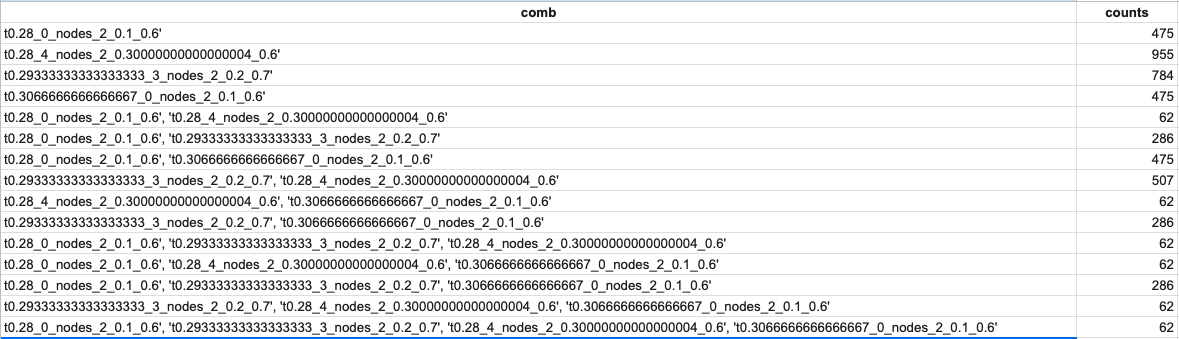

###complexes unique to each parameter setting

In [ ]:
cellSpecific_complexes.keys()

dict_keys(['t0.28_0_nodes_2_0.1_0.6', 't0.28_4_nodes_2_0.30000000000000004_0.6', 't0.29333333333333333_3_nodes_2_0.2_0.7', 't0.3066666666666667_0_nodes_2_0.1_0.6'])

In [ ]:
uniqueComplexes_param = \
  pd.DataFrame(
      {'param': param,
       'count': len(
          set(df['complex'].to_list()).difference(
              set().union(*[set(cellSpecific_complexes[paramOther]['complex'].to_list())
              for paramOther in cellSpecific_complexes.keys()
              if paramOther is not param]))
       )}
      for param, df in cellSpecific_complexes.items())

In [ ]:
uniqueComplexes_param

,param,count
0,t0.28_0_nodes_2_0.1_0.6,0
1,t0.28_4_nodes_2_0.30000000000000004_0.6,448
2,t0.29333333333333333_3_nodes_2_0.2_0.7,53
3,t0.3066666666666667_0_nodes_2_0.1_0.6,0


In [ ]:
set(cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['complex'].to_list()).difference(
    set().union(*
        [set(cellSpecific_complexes['t0.28_4_nodes_2_0.30000000000000004_0.6']['complex'].to_list()),
             set(cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7']['complex'].to_list()),
                 set(cellSpecific_complexes['t0.3066666666666667_0_nodes_2_0.1_0.6']['complex'].to_list())])
)

set()

In [ ]:
set(cellSpecific_complexes['t0.3066666666666667_0_nodes_2_0.1_0.6']['complex'].to_list()).difference(
    set().union(*
        [set(cellSpecific_complexes['t0.28_4_nodes_2_0.30000000000000004_0.6']['complex'].to_list()),
             set(cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7']['complex'].to_list()),
                 set(cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['complex'].to_list())])
)

set()

In [ ]:
set(cellSpecific_complexes['t0.29333333333333333_3_nodes_2_0.2_0.7']['complex'].to_list()).difference(
    set().union(*
        [set(cellSpecific_complexes['t0.28_4_nodes_2_0.30000000000000004_0.6']['complex'].to_list()),
             set(cellSpecific_complexes['t0.3066666666666667_0_nodes_2_0.1_0.6']['complex'].to_list()),
                 set(cellSpecific_complexes['t0.28_0_nodes_2_0.1_0.6']['complex'].to_list())])
)